# Rolling futures

#### by Gustavo Soares

In this notebook you will apply a few things you learned in our Python lecture [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, date variables, floats, dictionaries, lists, list comprehensions, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements and loops, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a Bloomberg terminal. If you are using this notebook within BQNT, you may want to use BQL for getting the data.

## Introduction to Futures trading

Futures contracts, or *futures* for short, are financial contracts obligating the buyer to purchase an asset or the seller to sell an asset at predetermined future date, $T$, and price, $F_{T}$. A futures contract allows an investor to speculate on the direction of a security, commodity, or a financial instrument wihtout having to buy or sell the actual underlying instrument. This is so, because:

* If the investor thinks the price of the underlying asset at the future date, $T$, will be $S_{T} > F_{T}$, then the investor can buy the underlying using a futures contract. At maturity, $T$, the investor is obliged to buy the underlying from the seller of the futures contract by $F_{T}$. If the investor is right and the underlying asset actually has the predicted price $S_{T}$, then the investor can purchase the asset from the futures sellers by $F_{T}$, sell the asset in the market by $S_{T}$ immediately and profit the difference $F_{T} - S_{T}$.

* If the investor thinks the price of the underlying asset at the future date, $T$, will be $S_{T} < F_{T}$, then the investor can sell the underlying using a futures contract. At maturity, $T$, the investor is obliged to sell the underlying from the buyer of the futures contract by $F_{T}$. If the investor is right and the underlying asset actually has the predicted price $S_{T}$, then the investor can buy the asset in the market by $S_{T}$ and then immediately sell the asset to the futures buyer by $F_{T}$ and profit the difference $S_{T} - F_{T}$.

Note that since the investor is buying and selling the underlying asset on the same day $T$, it actually does not need to own the underlying asset in order to profit from its price movements. You can actually buy and sell very large sums without really having much money in my back account. This is called *leverage* and is one of the most attractive features of trading futures contracts in quantitative strategies.

Leverage means that the investor does not need to put up 100% of the contract's value amount when entering into a trade. Instead, the broker would require an initial margin amount, which consists of a fraction of the total contract value. The amount held by the broker can vary depending on the size of the contract, the creditworthiness of the investor, and the broker's terms and conditions.

In fact, the investor does not even need to wait for the maturity of the futures contract. If on date $t_{0}$, the investor buy or sells the futures contract with expiration date $T$, it will trade at the price $F_{t_{0},T}$. If in a future date, $t \le T$, the investors closes the position selling or buying the futures contract with expiration date $T$ for the prevailing price $F_{t,T}$, it will profit the diffence in the futures contract price $F_{t,T} - F_{t_{0},T}$ without ever having to put down any money except for the initial margin amount.

## Bloomberg futures tickers

Each futures contract on Bloomberg has two or three letter tickers. For example, JB denotes the futures on Japanese Government 10 Year Bonds, CL denotes the futures on WTI crude oil, GC represents gold futures, OD for DI-1 futures, etc. Each futures contract has a particular reference month assocciated with it and each reference month is denoted by an alphabet letter. The dictionary below maps each letter to each reference calendar month:

In [1]:
ref_month_dict = {
    'Jan' : 'F',
    'Feb' : 'G',
    'Mar' : 'H',
    'Apr' : 'J',
    'May' : 'K',
    'Jun' : 'M',
    'Jul' : 'N',
    'Aug' : 'Q',
    'Sep' : 'U',
    'Oct' : 'V',
    'Nov' : 'X',
    'Dec' : 'Z'
}

Let's import `Pandas` to deal with the date variables and show how Bloomberg tickers work. Historically, futures were commonly used to trade commodities like crude oil, natural gas, gold, corn, and wheat. However, today there are stock index futures such as the S&P 500 Index or the EURO STOXX 50, currency futures, and bond futures such as US Treasury futures. Still, Bloomberg typically, though not always, keeps the ' Comdty' sufix on tickers for futures.

In [2]:
import pandas as pd

futures_ticker = 'CL'
ref_date = pd.to_datetime('2018-07-1')
ref_month = ref_month_dict[ref_date.strftime('%b')]
bloomberg_ticker = futures_ticker + ref_month + ref_date.strftime('%y') + ' Comdty'
print('The WTI crude oil futures contract with reference month %s is denoted by Bloomberg by %s' % (ref_date.strftime('%b-%y'),
                                                                                                   bloomberg_ticker))

futures_ticker = 'JB'
ref_date = pd.to_datetime('2016-03-1')
ref_month = ref_month_dict[ref_date.strftime('%b')]
bloomberg_ticker = futures_ticker + ref_month + ref_date.strftime('%y') + ' Comdty'
print('The Japanese Government 10 Year Bond futures contract with reference month %s is denoted by Bloomberg by %s' % (ref_date.strftime('%b-%y'),
                                                                                                   bloomberg_ticker))
futures_ticker = 'GC'
ref_date = pd.to_datetime('2016-04-1')
ref_month = ref_month_dict[ref_date.strftime('%b')]
bloomberg_ticker = futures_ticker + ref_month + ref_date.strftime('%y') + ' Comdty'
print('The Gold futures contract with reference month %s is denoted by Bloomberg by %s' % (ref_date.strftime('%b-%y'),
                                                                                                   bloomberg_ticker))

The WTI crude oil futures contract with reference month Jul-18 is denoted by Bloomberg by CLN18 Comdty
The Japanese Government 10 Year Bond futures contract with reference month Mar-16 is denoted by Bloomberg by JBH16 Comdty
The Gold futures contract with reference month Apr-16 is denoted by Bloomberg by GCJ16 Comdty


### The futures curve

The futures *curve* is a chart that depicts the contract maturity $T$ on the x-axis and the prevailing price for that underlying future the $F_{T}$. Naturally, the futures *curve* is continously changing as futures prices are constinously changing with market conditions. So, a *curve* is associated with a particular point in time $t$ and we can think of it as a chart of $\{(T,F_{t,T})\}_{T}$ for the different contract maturities $T$. On any particular date $t$, the futures curve can be $\{(T,F_{t,T})\}_{T}$ depicted in two ways:

* Generic tickers or constant maturity
* Fixed or constant expiries

Let's look at these two different was of thinking about futures curves.

For different dates, the futures curve, $\{(T,F_{t,T})\}_{T}$ will be different not only because the prices $\{(F_{t,T})\}_{T}$ themselves are different for different $t$'s but also because the maturities available are different. For example, on $t_{0}$ = 2018-07-01, the contract with reference month $T$ = Dec-2021 may not exist or may not be liquid enough but by $t_{1}$ = 2018-12-01 this contract will already exist so $\{(T,F_{t_{0},T})\}_{T}$ and $\{(T,F_{t_{1},T})\}_{T}$ do not share the same set of maturities $T$ because $T$ = Dec-2021 belongs to $\{(T,F_{t_{1},T})\}_{T}$ but not to $\{(T,F_{t_{0},T})\}_{T}$.

One way of dealing with this is to think about curves in terms of *generic tickers*. Let's use the integers $i=1,....,K$ to denote the contracts ordered from the shortest maturity to the largest maturity. So, $\{(T_{t,i},F_{t,T_{t,i}})\}_{i}$ now can denote a futures curve for any day ordered by maturity. On Bloomberg, this is done by using the two/three letter contract ticker XX added by a integer $i$ which denotes the order of the contract in the ascending sorted list of contract maturities. For example, 'JB1 Comdty', 'JB2 Comdty', and 'JB3 Comdty' are the tickers that, on that particular date, reference the Japanese Government 10 Year Bond futures contract with shortest maturity, second-shortest maturity, and third-shortest maturity, respectively. We typically, call these contracts the "front-month", "the second contract", and the "third contract".

Let's now import [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from Bloomberg and show how we can look manipulate futures curves using generic tickers. Before you do that you need to make sure that the directory where you placed the FinanceHub project is in the python's root directory.

In [3]:
import sys
sys.path
finance_hub_path_name = r'C:\Users\gsoares\Dropbox\FinanceHub' # change this to your path name
if finance_hub_path_name not in sys.path:
    sys.path.append(finance_hub_path_name) # this will append the FinanceHub folder into the python's root directory if not there
sys.path   

['',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\python36.zip',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\DLLs',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36',
 'C:\\Users\\gsoares\\AppData\\Roaming\\Python\\Python36\\site-packages',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\twixreader-1.0-py3.6.egg',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\win32',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\gsoares\\AppData\\Local\\Continuum\\anaconda3\\envs\\py36\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\gsoares\\AppData\\Roaming\\Python\\Python36\\site-packages\\IPython\\e

If your finance_hub_path_name shows up in the sys.path above, you are all good!

The future #1 of the WTI crude oil futures curve is denoted by Bloomberg by CL1 Comdty
It's actual ticker is CLF0 Comdty
It's last tradable date (expiry) is 19-Dec-19

The future #2 of the WTI crude oil futures curve is denoted by Bloomberg by CL2 Comdty
It's actual ticker is CLG0 Comdty
It's last tradable date (expiry) is 21-Jan-20

The future #3 of the WTI crude oil futures curve is denoted by Bloomberg by CL3 Comdty
It's actual ticker is CLH0 Comdty
It's last tradable date (expiry) is 20-Feb-20

The future #4 of the WTI crude oil futures curve is denoted by Bloomberg by CL4 Comdty
It's actual ticker is CLJ0 Comdty
It's last tradable date (expiry) is 20-Mar-20

The future #5 of the WTI crude oil futures curve is denoted by Bloomberg by CL5 Comdty
It's actual ticker is CLK0 Comdty
It's last tradable date (expiry) is 21-Apr-20

The future #6 of the WTI crude oil futures curve is denoted by Bloomberg by CL6 Comdty
It's actual ticker is CLM0 Comdty
It's last tradable date (expiry) is 19-

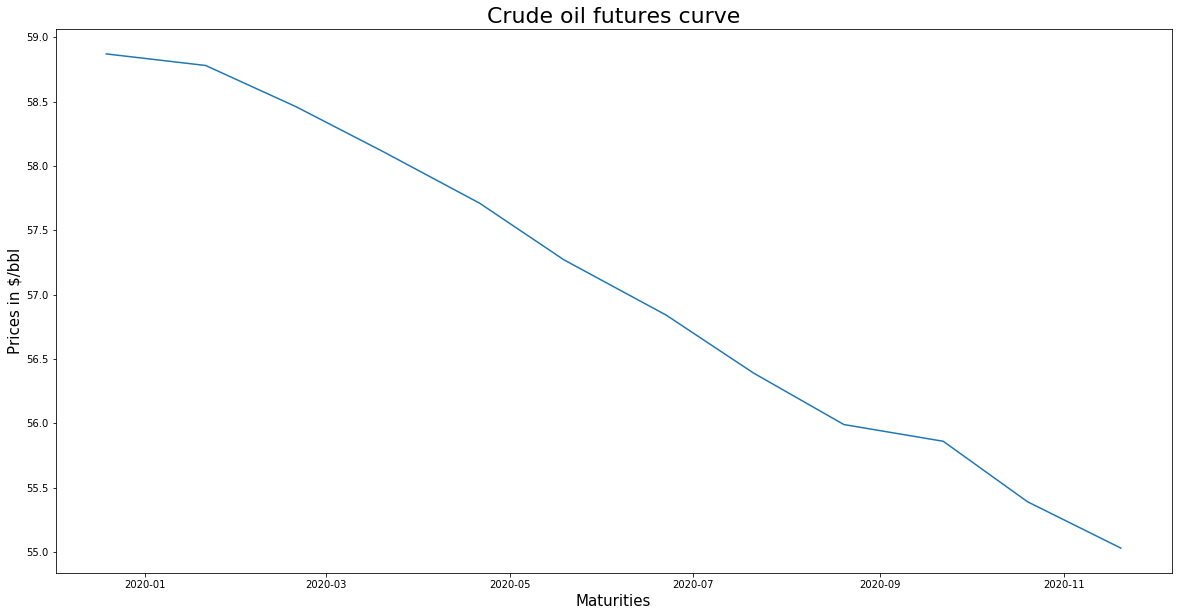

In [4]:
from bloomberg import BBG
import matplotlib.pyplot as plt
%matplotlib inline
# this line above is only neeeded when using the matplotlib library in an interactive platform like Jupyter Notebooks

bbg = BBG() # because BBG is a class, we need to create an instance of the BBG class wihtin this notebook, here deonted by bbg

futures_ticker = 'CL'
futures_ticker_list = []
contract_maturity = []
prices = []
for i in range(1,13):
    # define generic ticker
    fut_generic_ticker = futures_ticker + str(i) + ' Comdty'
    print('The future #%s of the WTI crude oil futures curve is denoted by Bloomberg by %s' % (i,fut_generic_ticker))
    
    # get actual ticker
    fut_ticker_df = bbg.fetch_contract_parameter(securities=fut_generic_ticker, field='FUT_CUR_GEN_TICKER')
    fut_ticker_str = fut_ticker_df.loc[fut_generic_ticker,'FUT_CUR_GEN_TICKER'] + ' Comdty'
    print("It's actual ticker is %s" % fut_ticker_str)    
    futures_ticker_list.append(fut_ticker_str)
    
    # get expiry date
    fut_mat_df = bbg.fetch_contract_parameter(securities=fut_ticker_str, field='LAST_TRADEABLE_DT')
    fut_mat_dt = pd.to_datetime(fut_mat_df.loc[fut_ticker_str,'LAST_TRADEABLE_DT'])
    print("It's last tradable date (expiry) is %s\n" % fut_mat_dt.strftime('%d-%b-%y'))
    contract_maturity.append(fut_mat_dt)
    
    # get price
    price_df = bbg.fetch_contract_parameter(securities=fut_ticker_str, field='PX_LAST')
    fut_price = price_df.loc[fut_ticker_str,'PX_LAST']
    prices.append(fut_price)
    

# plot the curve
plt.figure(figsize=(20,10))
plt.plot(contract_maturity,prices)
plt.title('Crude oil futures curve',fontsize=22)
plt.xlabel('Maturities',fontsize=15)
plt.ylabel('Prices in $/bbl',fontsize=15)
plt.show()

We have done this in a loop but we can also do it in bulk using [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg):

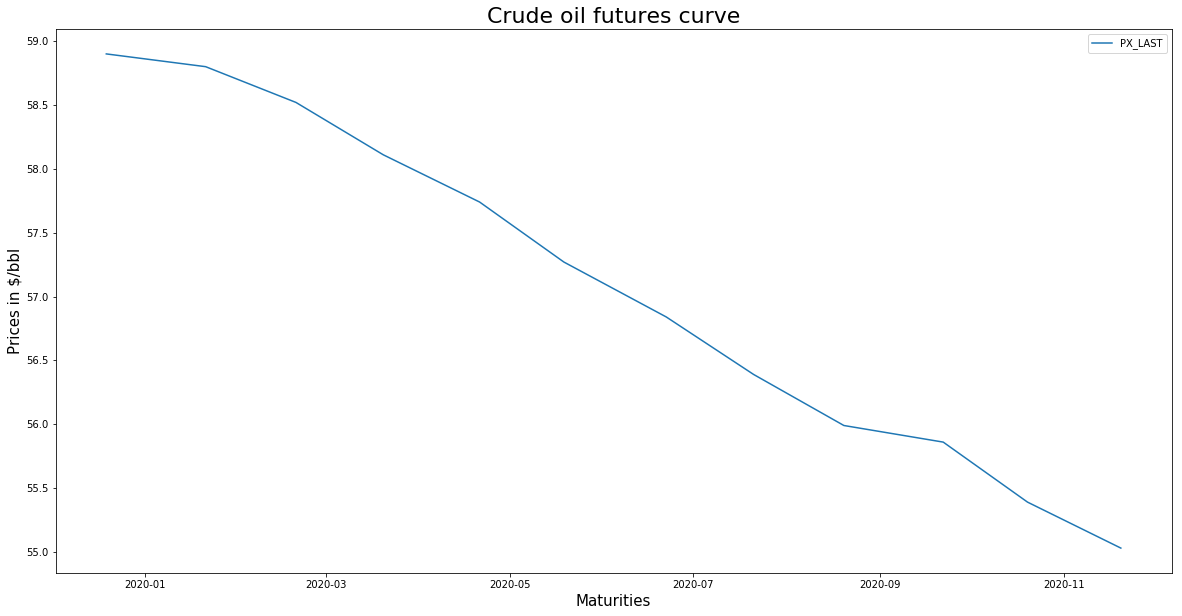

In [5]:
ref_date = pd.to_datetime('today')
generic_ticker_list = ['CL' + str(i) + ' Comdty' for i in range(1,13)]

# underlying contracts
# note that the actual tickers for the generic tickers in generic_ticker_list change every day
# so we need to download them using the BBG class fetch_series method and give it a reference date ref_date
df_uc = bbg.fetch_series(securities=generic_ticker_list,
             fields='FUT_CUR_GEN_TICKER', # this is a historical field so not available under fetch_contract_parameter function
             startdate=ref_date,
             enddate=ref_date)
actual_ticker_list = [x + ' Comdty' for x in df_uc.squeeze().values]

# get maturities
# note that the actual tickers expiry are static fileds so we can use fetch_contract_parameter function
fut_mat_df = bbg.fetch_contract_parameter(securities=actual_ticker_list, field='LAST_TRADEABLE_DT')

# get prices
# px_last is not a static filed but using fetch_contract_parameter function here just picks the most recent price published
curve_df = bbg.fetch_contract_parameter(securities=actual_ticker_list, field='PX_LAST')
curve_df = pd.concat([fut_mat_df,curve_df],axis=1).set_index('LAST_TRADEABLE_DT')

# plot the curve
curve_df.plot(figsize=(20,10))
plt.title('Crude oil futures curve',fontsize=22)
plt.xlabel('Maturities',fontsize=15)
plt.ylabel('Prices in $/bbl',fontsize=15)
plt.show()

### Historical curve data

Suppose now that we would like to download the futures curve over time. In Econometrics language, this is an unbalaced panel because for every date $t \in \{0, \dots, T\}$ we have a set of futures contracts with maturities $\{T_{t,i}\:i = k_{t,0}, \dots,k_{t,K_{t}}\}$ and prices $\{F_{t,i}\:i = k_{t,0}, \dots,k_{t,K_{t}}\}$ where the set of contracts available on that $t$ date, $\{k_{t,0}, \dots,k_{t,K_{t}}\}$ potentially changes. In `Pandas.DataFrame` language, this means we have a dataframe like the curve_df above for every date $t$ in the period:

In [6]:
curve_df

,PX_LAST
LAST_TRADEABLE_DT,
2020-06-22,56.84
2020-07-21,56.39
2020-08-20,55.99
2019-12-19,58.90
2020-01-21,58.80
2020-09-22,55.86
2020-02-20,58.52
2020-03-20,58.11
2020-10-20,55.39


What we will do is to create a dataframe where in the rows we have the dates we are interested in and in the columns we have all the contracts in the time periods. Of course, we will have nan's in this dataframe on the dates that a particular contract did not exist.

Let's get started by getting the tickers for the front-month contracts that ever existed using the fetch_futures_list() method of the BBG class:

In [7]:
contract_list = bbg.fetch_futures_list(generic_ticker='CL1 Comdty')
print(contract_list)

['CLM83 Comdty', 'CLN83 Comdty', 'CLQ83 Comdty', 'CLU83 Comdty', 'CLV83 Comdty', 'CLX83 Comdty', 'CLZ83 Comdty', 'CLF84 Comdty', 'CLG84 Comdty', 'CLH84 Comdty', 'CLJ84 Comdty', 'CLK84 Comdty', 'CLM84 Comdty', 'CLN84 Comdty', 'CLQ84 Comdty', 'CLU84 Comdty', 'CLV84 Comdty', 'CLX84 Comdty', 'CLZ84 Comdty', 'CLF85 Comdty', 'CLG85 Comdty', 'CLH85 Comdty', 'CLJ85 Comdty', 'CLK85 Comdty', 'CLM85 Comdty', 'CLN85 Comdty', 'CLQ85 Comdty', 'CLU85 Comdty', 'CLV85 Comdty', 'CLX85 Comdty', 'CLZ85 Comdty', 'CLF86 Comdty', 'CLG86 Comdty', 'CLH86 Comdty', 'CLJ86 Comdty', 'CLK86 Comdty', 'CLM86 Comdty', 'CLN86 Comdty', 'CLQ86 Comdty', 'CLU86 Comdty', 'CLV86 Comdty', 'CLX86 Comdty', 'CLZ86 Comdty', 'CLF87 Comdty', 'CLG87 Comdty', 'CLH87 Comdty', 'CLJ87 Comdty', 'CLK87 Comdty', 'CLM87 Comdty', 'CLN87 Comdty', 'CLQ87 Comdty', 'CLU87 Comdty', 'CLV87 Comdty', 'CLX87 Comdty', 'CLZ87 Comdty', 'CLF88 Comdty', 'CLG88 Comdty', 'CLH88 Comdty', 'CLJ88 Comdty', 'CLK88 Comdty', 'CLM88 Comdty', 'CLN88 Comdty', 'CLQ88 

Now, let's download the data for all of them in the relevant period:

In [8]:
start_date = '2016-01-05'
end_date = ref_date
df_prices = bbg.fetch_series(securities=contract_list,
                             fields='PX_LAST',
                             startdate=start_date,
                             enddate=end_date)
print('columns: %s' % df_prices.columns)
print('\nrows: %s' % df_prices.index)

columns: Index(['CLG88 Comdty', 'CLH88 Comdty', 'CLJ88 Comdty', 'CLK88 Comdty',
       'CLM88 Comdty', 'CLN88 Comdty', 'CLQ88 Comdty', 'CLU88 Comdty',
       'CLM93 Comdty', 'CLN93 Comdty',
       ...
       'CLU28 Comdty', 'CLX29 Comdty', 'CLM30 Comdty', 'CLJ29 Comdty',
       'CLN30 Comdty', 'CLK29 Comdty', 'CLZ29 Comdty', 'CLQ30 Comdty',
       'CLF30 Comdty', 'CLU30 Comdty'],
      dtype='object', length=573)

rows: DatetimeIndex(['2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08',
               '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14',
               '2016-01-15', '2016-01-19',
               ...
               '2019-11-29', '2019-12-02', '2019-12-03', '2019-12-04',
               '2019-12-05', '2019-12-06', '2019-12-09', '2019-12-10',
               '2019-12-11', '2019-12-12'],
              dtype='datetime64[ns]', length=994, freq=None)


So, on a particular date we have:

In [9]:
df_prices.loc['2019-12-03'].dropna()

CLV30 Comdty    52.07
CLX30 Comdty    52.07
CLZ30 Comdty    52.07
CLF31 Comdty    52.07
CLG31 Comdty    52.07
CLG0 Comdty     56.03
CLV0 Comdty     53.58
CLH0 Comdty     55.82
CLX0 Comdty     53.35
CLM1 Comdty     52.14
CLJ0 Comdty     55.52
CLG2 Comdty     51.33
CLN1 Comdty     51.99
CLV2 Comdty        51
CLH2 Comdty     51.26
CLK0 Comdty     55.19
CLZ0 Comdty     53.14
CLQ1 Comdty     51.86
CLM0 Comdty     54.86
CLF1 Comdty     52.92
CLU1 Comdty     51.75
CLJ2 Comdty      51.2
CLX2 Comdty     51.01
CLG1 Comdty     52.72
CLN0 Comdty     54.51
CLZ2 Comdty     51.03
CLV1 Comdty     51.66
CLH1 Comdty     52.55
CLQ0 Comdty     54.17
CLK2 Comdty     51.16
                ...  
CLK28 Comdty    52.07
CLX7 Comdty     52.08
CLZ28 Comdty    52.07
CLG30 Comdty    52.07
CLQ29 Comdty    52.07
CLM28 Comdty    52.07
CLJ7 Comdty     52.11
CLZ7 Comdty     52.07
CLF29 Comdty    52.07
CLH30 Comdty    52.07
CLN28 Comdty    52.07
CLU29 Comdty    52.07
CLF8 Comdty     52.07
CLK7 Comdty     52.12
CLG29 Comd

### First Notice Date

The First Notice Day (FND) is the day after which an investor who has purchased or sold a futures contract may be required to take physical delivery of the contract's underlying. In our case, here the investor would have to physically buy or sell a thousand barrels of oil. If we trade in and out of futures contracts before the FND, we will never have to physically buy or sell anything. So, in most quantitative strategies involving futures, we need to get our of the position before the FND otherwise we may be asked by the exchange to physically buy or sell the underlying futures. If you are trading oil futures after the FND you may end up owning a large number of barrels of oil in Cushing, Oklahoma which is the NYMEX delivery point for that contract!

Let's get the FND for the futures we are going to trade:

In [10]:
df_fnd = bbg.fetch_contract_parameter(securities=contract_list, field='FUT_NOTICE_FIRST').sort_values('FUT_NOTICE_FIRST')

So, in a particular date we have all the FND for all the contracts available:

In [11]:
df_fnd.loc[df_prices.loc['2019-12-03'].dropna().index].dropna()

,FUT_NOTICE_FIRST
CLV30 Comdty,2030-09-24
CLX30 Comdty,2030-10-24
CLZ30 Comdty,2030-11-22
CLF31 Comdty,2030-12-23
CLG31 Comdty,2031-01-23
CLG0 Comdty,2020-01-23
CLV0 Comdty,2020-09-24
CLH0 Comdty,2020-02-24
CLX0 Comdty,2020-10-22
CLM1 Comdty,2021-05-24


## Rolling futures

Let's now calculate a strategy that is buying crude oil front month futures, holding them for some time but then rolling out of them and into the next available contract before its FND. Let's start by setting up a dataframe that will hold the results:

In [12]:
# This is fetching the data for the front-month futures contract and the next available contract
df_generics = bbg.fetch_series(securities=['CL1 Comdty', 'CL2 Comdty'],
                               fields='PX_LAST',
                               startdate=start_date,
                               enddate=end_date)

# underlying contracts
df_uc = bbg.fetch_series(securities=['CL1 Comdty', 'CL2 Comdty'],
                         fields='FUT_CUR_GEN_TICKER',
                         startdate=start_date,
                         enddate=end_date)
df_uc = df_uc.reindex(df_generics.index).fillna(method='ffill')

# sets up the dataframe that will hold our results
df_tracker = pd.DataFrame(index=df_generics.index,
                          columns=['contract_rolling_out', 'er_index', 'roll_out_date', 'holdings'])

Let's now initialize the trade with USD 100 worth of notional on the second most nearby contract. We will hold $100/F_{0,T_{2}}$ barrels of oil. We will check the FND of the contract we are trading so we know we have to roll out of the position the day before. We need to keep track of that date, so we need to store it in the dataframe as well.

In [13]:
from pandas.tseries.offsets import BDay
# this line above is for us to use the function BDay to subtract business days

# initialize
start_date = df_uc.index[0]
df_tracker.loc[start_date, 'er_index'] = 100

contract_rolling_out = df_uc.loc[start_date, 'CL2 Comdty'] + ' Comdty'
df_tracker.loc[start_date, 'contract_rolling_out'] = contract_rolling_out

holdings = df_tracker.loc[start_date, 'er_index'] / df_generics.loc[start_date, 'CL2 Comdty']
df_tracker.loc[start_date, 'holdings'] = holdings

roll_out_date = df_fnd.loc[df_tracker.loc[start_date, 'contract_rolling_out'], 'FUT_NOTICE_FIRST'] - BDay(1)
df_tracker.loc[start_date, 'roll_out_date'] = roll_out_date

Now, let's store the PNL of that position as an excess return index (the 'er_index' column in our dataframe). When we come to the roll date, we need to close out the position and open a new one:

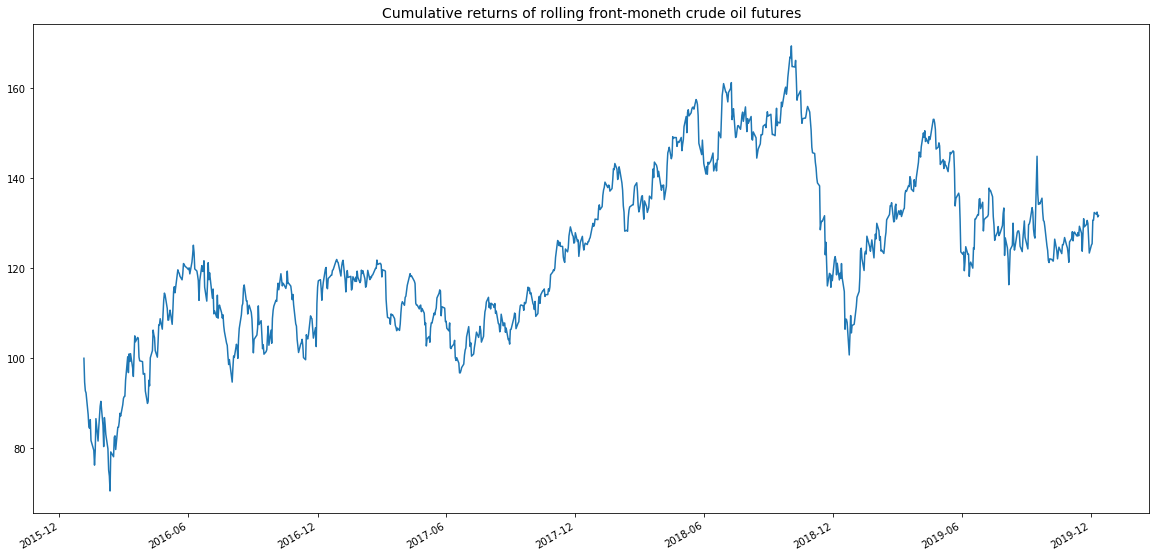

In [14]:
import math
for d, dm1 in zip(df_tracker.index[1:], df_tracker.index[:-1]):
    df_tracker.loc[d, 'contract_rolling_out'] = contract_rolling_out

    price_dm1 = df_prices.loc[dm1, contract_rolling_out]
    price_d = df_prices.loc[d, contract_rolling_out]
    pnl = holdings * (price_d - price_dm1)

    if math.isnan(pnl):
        pnl = 0

    df_tracker.loc[d, 'er_index'] = df_tracker.loc[dm1, 'er_index'] + pnl

    if d >= roll_out_date:
        contract_rolling_out = (df_uc.loc[d, 'CL2 Comdty'] + ' Comdty')
        df_tracker.loc[d, 'contract_rolling_out'] = contract_rolling_out

        holdings = df_tracker.loc[d, 'er_index'] / df_generics.loc[d, 'CL2 Comdty']
        df_tracker.loc[d, 'holdings'] = holdings

        roll_out_date = df_fnd.loc[df_tracker.loc[d, 'contract_rolling_out'], 'FUT_NOTICE_FIRST'] - BDay(1)
        df_tracker.loc[d, 'roll_out_date'] = roll_out_date

df_tracker['er_index'].plot(figsize=(20,10))
plt.title('Cumulative returns of rolling front-moneth crude oil futures',fontsize=14)
plt.show()

### Exercises

#### Beginners

Take the code from this notebook and try to create a script that plots the excess return for rollings contracts at a given roll schedule. For example, you can try to roll Dec-15 Natural Gas contracts into the Dec-16 Natural Gas contract and then roll that contract into Dec-17 Natural Gas right before the FND of the Dec-16 Natural Gas, and so forth ...

#### Beginners/Intermediate

DI-1 futures at BMF-B3 are denoted on Bloobmerg by the two letter OD, so the front-month DI-1 futures is denoted by OD1 Comdty. The way we calculate the PNL for a DI-1 futures is different from what we have here. See details of the contract [here](http://www.b3.com.br/en_us/products-and-services/trading/interest-rates/one-day-interbank-deposit-futures.htm) So, the line `pnl = holdings * (price_d - price_dm1)` does not work for DI-1 futures. See if you can adapt this notebook to calculate the PNL of holding and rolling DI-1 futures and calculate the returns of rolling Jan DI-1 contracts over 5 years.

#### Beginners/Intermediate

Some futures contracts are denominated in different currencies. For example, Japanese Government 10Y Bonds futures, JB on Bloomberg, are denominated in Japanese yens. The code above would produce the returns in Japanese yens but what would be the returns for a BRL based investor? Try to adapt this code for this case but remember that the BRLJPY exchange rate only affects the pnl of the strategy since there is no actual investment when you buy a futures contract.

#### Advanced/Master

Check out [FinanceHub's Bond Futures Tracker Class](https://github.com/Finance-Hub/FinanceHub/blob/master/trackers/BondFutures/bondfuturetracker.py) and see if you can generalize that class of rolling bond futures to also cope with rolling FX futures.

#### Advanced/Master

Check out [FinanceHub's Bond Futures Tracker Class](https://github.com/Finance-Hub/FinanceHub/blob/master/trackers/BondFutures/bondfuturetracker.py) and see if you can generalize that class of rolling bond futures to also cope with rolling Equity Index futures.

#### For Jedi masters

Check out [FinanceHub's Commodity Futures Tracker Class](https://github.com/Finance-Hub/FinanceHub/blob/master/trackers/Commodities/comm_futures_tracker.py) and see if you can generalize that class of rolling commodity futures to also cope with rolling Bond, FX, and Equity Index futures.